In [6]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Function to load and preprocess data
def load_and_preprocess_data():
    # Load the datasets
    print("Loading datasets...")
    df_net = pd.read_csv('data/linux_driver_net.csv')
    df_scsi = pd.read_csv('data/linux_driver_scsi.csv')
    df_ext3 = pd.read_csv('data/linux_ext3.csv')
    df_ipv4 = pd.read_csv('data/linux_ipv4.csv')
    
    # Combine datasets
    combined_df = pd.concat([df_net, df_scsi, df_ext3, df_ipv4], ignore_index=True)
    
    # Check for missing values
    print(f"Missing values before preprocessing: {combined_df.isnull().sum().sum()}")
    
    # Fill missing values - use mean for numeric columns
    numeric_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
    combined_df[numeric_columns] = combined_df[numeric_columns].fillna(combined_df[numeric_columns].mean())
    
    # Drop any rows that still have missing values
    combined_df = combined_df.dropna()
    
    # Check for imbalance in the target variable
    print("Class distribution:")
    print(combined_df['AgingRelatedBugs'].value_counts())
    print(f"Imbalance ratio: {combined_df['AgingRelatedBugs'].value_counts()[0] / combined_df['AgingRelatedBugs'].value_counts()[1]}")
    
    # Prepare features and target
    X = combined_df.drop(['Filename', 'AgingRelatedBugs'], axis=1)
    y = combined_df['AgingRelatedBugs']
    
    # Feature scaling 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, X.columns

In [8]:
# Function to calculate Error I and Error II
def calculate_error_rates(y_true, y_pred):
    """
    Calculate Type I and Type II error rates
    Type I: False Positives / (False Positives + True Negatives)
    Type II: False Negatives / (True Positives + False Negatives)
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Type I error - classifying bad credit as good
    error_I = fp / (fp + tn) * 100  # as percentage
    
    # Type II error - classifying good credit as bad
    error_II = fn / (tp + fn) * 100  # as percentage
    
    return error_I, error_II

In [9]:
# Function to create balanced training data
def create_balanced_data(X, y):
    """
    Creates train/test splits and applies SMOTE to balance the training set
    """
    # Split data into training, dynamic selection, and testing sets (33%, 33%, 33%)
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42, stratify=y_train_temp)
    
    # Count minority samples
    minority_count = Counter(y_train)[1]
    
    # Choose appropriate k for SMOTE based on minority class size
    k_neighbors = min(5, minority_count - 1)  # Must be less than minority count
    
    # Apply SMOTE with adjusted k_neighbors
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("Original training set class distribution:", Counter(y_train))
    print("Balanced training set class distribution:", Counter(y_train_balanced))
    
    return X_train, y_train, X_train_balanced, y_train_balanced, X_dsel, y_dsel, X_test, y_test


In [10]:
# Function to train and evaluate XGBoost
def train_evaluate_xgboost(X_train, y_train, X_test, y_test, use_balanced=True):
    """
    Train XGBoost model and evaluate performance
    """
    # Set parameters specifically for imbalanced classification
    scale_pos_weight = Counter(y_train)[0] / Counter(y_train)[1]  # Weight for positive class
    
    print(f"\nTraining XGBoost {'on balanced data' if use_balanced else 'on original data'}...")
    # Initialize the model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,  # Adjust for class imbalance
        learning_rate=0.1,
        n_estimators=100,
        max_depth=4,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        eval_metric='auc',  # using AUC for evaluation
        random_state=42
    )
    
    # Train the model
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_prob)
    error_I, error_II = calculate_error_rates(y_test, y_pred)
    
    # Print results
    print("\nResults:")
    print(f"AUC: {auc:.4f}")
    print(f"Error I (%): {error_I:.2f}")
    print(f"Error II (%): {error_II:.2f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Visualizations
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('xgboost_confusion_matrix.png')
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('xgboost_roc_curve.png')
    
    return model, y_pred, y_prob, auc, error_I, error_II


Loading datasets...
Missing values before preprocessing: 0
Class distribution:
AgingRelatedBugs
0    3380
1      20
Name: count, dtype: int64
Imbalance ratio: 169.0
Original training set class distribution: Counter({0: 1132, 1: 7})
Balanced training set class distribution: Counter({1: 1132, 0: 1132})

Training XGBoost on balanced data...

Results:
AUC: 0.8759
Error I (%): 1.61
Error II (%): 85.71

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1115
           1       0.05      0.14      0.08         7

    accuracy                           0.98      1122
   macro avg       0.52      0.56      0.53      1122
weighted avg       0.99      0.98      0.98      1122


Confusion Matrix:
[[1097   18]
 [   6    1]]

Training XGBoost on original data...

Results:
AUC: 0.8716
Error I (%): 0.27
Error II (%): 85.71

Classification Report:
              precision    recall  f1-score   support

           0       0.99   

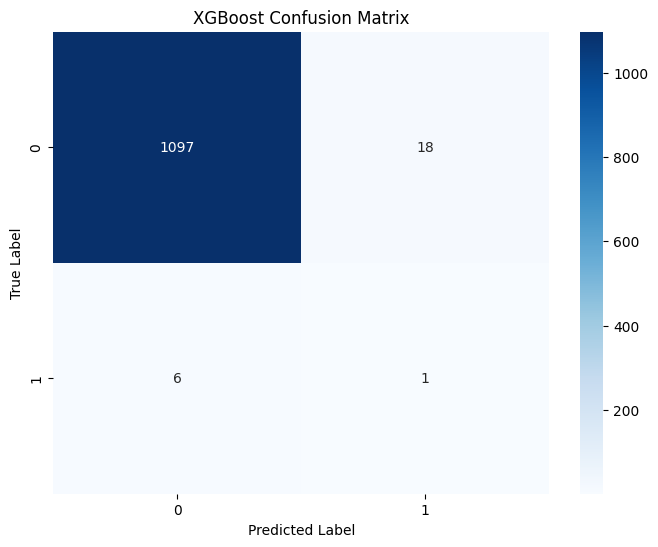

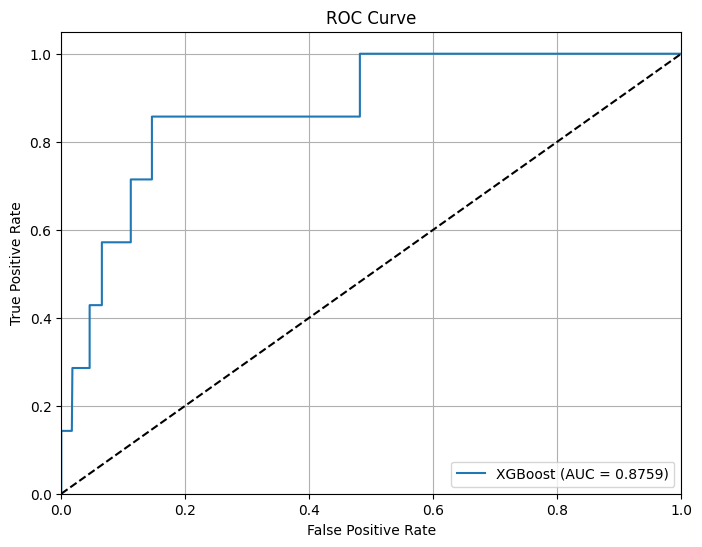

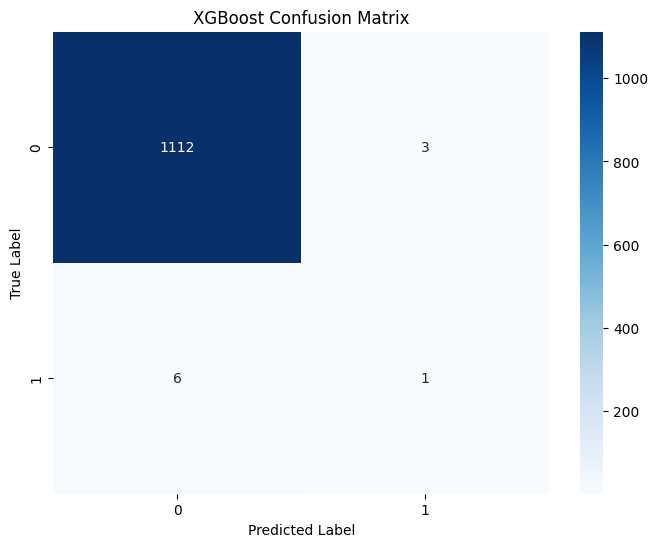

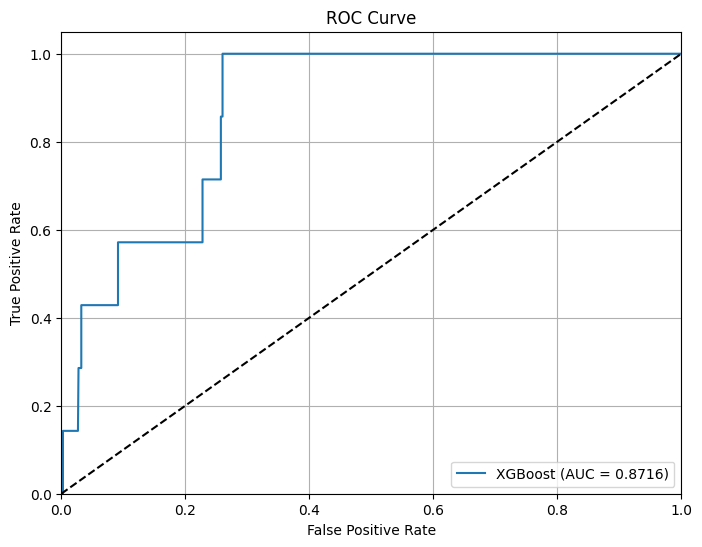

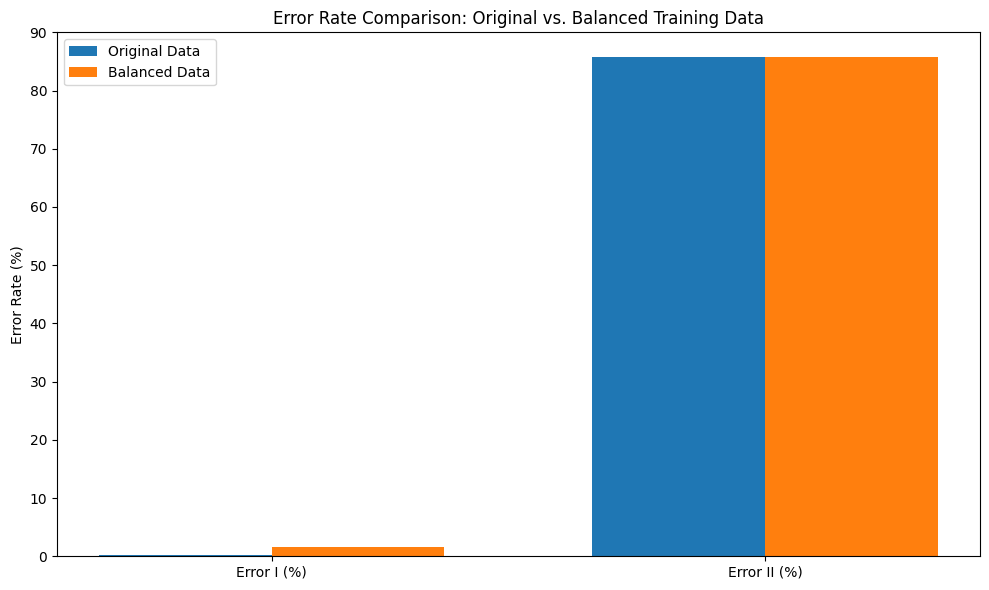

In [11]:
# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    X, y, feature_names = load_and_preprocess_data()
    
    # Create training and test sets
    X_train, y_train, X_train_balanced, y_train_balanced, X_dsel, y_dsel, X_test, y_test = create_balanced_data(X, y)
    
    # Train and evaluate XGBoost on balanced data
    model_balanced, y_pred_balanced, y_prob_balanced, auc_balanced, error_I_balanced, error_II_balanced = train_evaluate_xgboost(X_train_balanced, y_train_balanced, X_test, y_test, use_balanced=True)
    
    # Train and evaluate XGBoost on original unbalanced data
    model_original, y_pred_original, y_prob_original, auc_original, error_I_original, error_II_original = train_evaluate_xgboost(X_train, y_train, X_test, y_test, use_balanced=False)
    
    # Print comparison
    print("\n" + "="*50)
    print("XGBoost Models Comparison:")
    print("="*50)
    print(f"{'Metric':<15} {'Original Data':>20} {'Balanced Data':>20}")
    print("-"*60)
    print(f"{'AUC':.<15} {auc_original:>20.4f} {auc_balanced:>20.4f}")
    print(f"{'Error I (%)':.<15} {error_I_original:>20.2f} {error_I_balanced:>20.2f}")
    print(f"{'Error II (%)':.<15} {error_II_original:>20.2f} {error_II_balanced:>20.2f}")
    print("="*60)
    
    # Save comparison plot
    plt.figure(figsize=(10, 6))
    x = np.arange(2)
    width = 0.35
    
    plt.bar(x - width/2, [error_I_original, error_II_original], width, label='Original Data')
    plt.bar(x + width/2, [error_I_balanced, error_II_balanced], width, label='Balanced Data')
    
    plt.xticks(x, ['Error I (%)', 'Error II (%)'])
    plt.ylabel('Error Rate (%)')
    plt.title('Error Rate Comparison: Original vs. Balanced Training Data')
    plt.legend()
    plt.tight_layout()
    plt.savefig('xgboost_comparison.png')
    
    print("\nAnalysis complete! Visualizations saved as PNG files.")
    
    # Save results to a CSV for easy comparison with META-DESKNN-MI later
    results_df = pd.DataFrame({
        'Metric': ['AUC', 'Error I (%)', 'Error II (%)'],
        'XGBoost (Original)': [auc_original, error_I_original, error_II_original],
        'XGBoost (Balanced)': [auc_balanced, error_I_balanced, error_II_balanced]
    })
    
    results_df.to_csv('xgboost_results.csv', index=False)
    print("Results saved to 'xgboost_results.csv'")

In [12]:
from IPython.display import display
from pandas.plotting.style import Styler

ModuleNotFoundError: No module named 'pandas.plotting.style'

In [ ]:
# Display the styled DataFrame
display(results_df.style.format({
    'XGBoost (Original)': '{:.4f}' if idx == 0 else '{:.2f}' for idx in range(3),
    'XGBoost (Balanced)': '{:.4f}' if idx == 0 else '{:.2f}' for idx in range(3)
}))